In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.stats import sem, t
from skopt import gp_minimize
import optuna
import random

In [2]:
def get_city_coord_dict(filename):
    '''Opens the file with cities and corresponding coordinates. Puts it in an ordered dictionary.
    Input: file name with path.
    Ouput: Ordered dictionary of cities with corresponding x and y coordinates in a numpy array.'''
    city_coord_dict = {}

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line[0].isdigit():
                split = line.split()

                city_coord_dict[int(split[0])] = np.array([int(coord) for coord in line.split()[-2:]])

    return OrderedDict(city_coord_dict)

#Open initial file, store cities with coordinates
filename = "TSP-Configurations/a280.tsp.txt"
init_cities = get_city_coord_dict(filename)

def get_distance(city_a, city_b):
    '''Calculates distance between city a and city b.
    Input: numpy arrays of city_a and city_b coordinates.
    Output: Euclidean distance between the two cities (as a scalar)'''
    return np.linalg.norm(city_a - city_b)

def total_distance(cities):
    '''Calculates the total distance of the route of visiting all cities in order specified.
    Input: OrderedDict of cities (keys) with their coordinates (np.arrays of x and y)
    Output: Total route distance (scalar)'''

    city_coords = list(cities.values())

    #Init variable: link last city with first
    total_distance = get_distance(city_coords[-1], city_coords[0])
    
    #Connect every subsequent pair of cities
    for i in range(len(cities) -1):
        total_distance += get_distance(city_coords[i], city_coords[i+1])

    return total_distance

def visualize_routes(cities):
    '''Visualize the cities on a plane and the routes between cities.
    Input: OrderedDict of cities (keys) and coordinates(values).
    Output: plot of cities and routes between them.
    '''
    city_coords = list(cities.values())
    for city in city_coords:
        plt.scatter(city[0], city[1])

    #Add connecting lines 
    for i in range(len(city_coords) - 1):
        plt.plot([city_coords[i][0], city_coords[i+1][0]], [city_coords[i][1], city_coords[i+1][1]])

    #Connect last city to first
    plt.plot([city_coords[-1][0], city_coords[0][0]], [city_coords[-1][1], city_coords[0][1]])
    plt.show()

# Nearest Neighbour 

In [3]:
class SimulatedAnnealing:
    def __init__(self, cities, C, T0, max_step=100, init_seed=1):
        self.cities_old = cities
        self.C = C
        self.T0 = T0
        self.max_step = max_step
        self.init_seed = init_seed
        self.step = 0

    def nearest_neighbor_heuristic(self):
        cities = list(self.cities_old.keys())
        current_city = random.choice(cities)
        solution = [current_city]

        while len(solution) < len(cities):
            distances = [(city, np.linalg.norm(np.array(self.cities_old[current_city]) - np.array(self.cities_old[city])))
                         for city in cities if city not in solution]
            next_city, _ = min(distances, key=lambda x: x[1])
            solution.append(next_city)
            current_city = next_city

        return OrderedDict((city, self.cities_old[city]) for city in solution)

    def proposal(self):
        cities_list = list(self.cities_old.keys())
        random_index = np.random.randint(0, len(cities_list) - 1)
        proposal_cities = self.cities_old.copy()

        # Swap neighboring cities
        city_a = cities_list[random_index]
        city_b = cities_list[random_index + 1]

        proposal_cities[city_a], proposal_cities[city_b] = proposal_cities[city_b], proposal_cities[city_a]

        return proposal_cities

    def evaluate(self, cities, proposal_cities, T):
        delta_distance = total_distance(proposal_cities) - total_distance(cities)
        alpha_func = min(np.exp(-delta_distance / T), 1)
        return alpha_func

    def select(self, alpha_func, proposal_cities):
        u = np.random.uniform()
        if u <= alpha_func:
            cities_new = proposal_cities
        else:
            cities_new = self.cities_old
        return cities_new

    def run(self):
        # Initial heuristic solution (nearest neighbor)
        initial_solution = self.nearest_neighbor_heuristic()
        self.cities_old = initial_solution

        while self.step < self.max_step:
            self.init_seed += 1
            T = (self.C * np.log(self.step + self.T0))**(-1)
            self.step += 1
            proposal_cities = self.proposal()
            alpha_func = self.evaluate(self.cities_old, proposal_cities, T)
            cities_new = self.select(alpha_func, proposal_cities)
            self.cities_old = cities_new

        return cities_new


/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_34849/1397037315.py:39: RuntimeWarning: overflow encountered in exp
  alpha_func = min(np.exp(-delta_distance / T), 1)


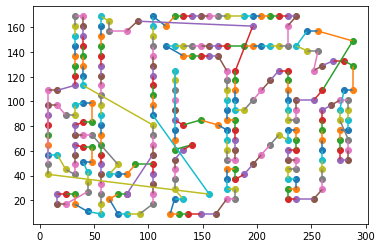

Total distance of simulated annealing solution is: 3182.471200320031
Order of the cities is as follows: odict_keys([157, 119, 120, 121, 122, 123, 124, 125, 30, 31, 32, 29, 28, 27, 26, 22, 25, 23, 24, 14, 13, 12, 11, 10, 8, 7, 9, 275, 274, 273, 272, 271, 16, 17, 18, 19, 20, 21, 128, 127, 126, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 178, 151, 152, 156, 153, 155, 154, 177, 176, 181, 180, 179, 182, 183, 184, 185, 187, 186, 189, 188, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 251, 250, 247, 244, 241, 240, 239, 238, 231, 232, 233, 234, 235, 236, 237, 246, 245, 243, 242, 2, 280, 3, 279, 278, 4, 277, 276, 6, 5, 1, 248, 249, 256, 255, 252, 253, 254, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 15, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 60, 61

In [6]:
#Run the simulator
if __name__== '__main__':
    sim_annealing = SimulatedAnnealing(cities = init_cities, C = 39, T0 = 659, max_step = 1000)
    cities_new = sim_annealing.run()
    visualize_routes(cities_new)
    print(f'Total distance of simulated annealing solution is: {total_distance(cities_new)}')
    print(f'Order of the cities is as follows: {cities_new.keys()}')

In [7]:
def objective_function(trial):
    # Define the hyperparameter search space
    C = trial.suggest_int('C', 0.1, 100)
    T0 = trial.suggest_int('T0', 10, 5000)
    max_step = trial.suggest_int('max_step', 100, 1000)

    # Run the Simulated Annealing algorithm with the suggested hyperparameters
    sim_annealing = SimulatedAnnealing(init_cities, C, T0, max_step)
    cities_new = sim_annealing.run()
    distance = total_distance(cities_new)

    return distance

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the study
study.optimize(objective_function, n_trials=20, show_progress_bar=True)

# Extract the best parameters
best_params = study.best_params
best_value = study.best_value

# Print the best parameters
print("Best Parameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Print the best objective value
print("Best Objective Value:", best_value)

[I 2023-12-11 16:40:27,932] A new study created in memory with name: no-name-4bd3883d-a7ff-491f-a7e5-330cdf5c2dfe


  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/lf/9kmpp6sj6r5336sq3nv74tjw0000gn/T/ipykernel_34849/1397037315.py:39: RuntimeWarning: overflow encountered in exp
  alpha_func = min(np.exp(-delta_distance / T), 1)


[I 2023-12-11 16:40:28,977] Trial 0 finished with value: 3253.3417468138405 and parameters: {'C': 52, 'T0': 4369, 'max_step': 226}. Best is trial 0 with value: 3253.3417468138405.
[I 2023-12-11 16:40:29,630] Trial 1 finished with value: 3156.8768450732528 and parameters: {'C': 5, 'T0': 1560, 'max_step': 128}. Best is trial 1 with value: 3156.8768450732528.
[I 2023-12-11 16:40:30,903] Trial 2 finished with value: 3275.4926033847905 and parameters: {'C': 64, 'T0': 1250, 'max_step': 307}. Best is trial 1 with value: 3156.8768450732528.
[I 2023-12-11 16:40:32,101] Trial 3 finished with value: 3226.013129940092 and parameters: {'C': 43, 'T0': 1201, 'max_step': 344}. Best is trial 1 with value: 3156.8768450732528.
[I 2023-12-11 16:40:32,766] Trial 4 finished with value: 3223.65982538934 and parameters: {'C': 75, 'T0': 3401, 'max_step': 137}. Best is trial 1 with value: 3156.8768450732528.
[I 2023-12-11 16:40:33,440] Trial 5 finished with value: 3149.182963943957 and parameters: {'C': 62, 'T0